In [1]:
from routines import sdss_utils
import matplotlib.pyplot as plt
import torch
from torch import nn 
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
### Gather all spectra
#Pytorch needs a tensor with dimensions (channel, height, width)
file_name = 'spectra_001_3.npy'
labels_name = 'labels_001_3.npy'
if os.path.exists(file_name):
    spectra = np.load(file_name)
    labels = np.load(labels_name)
else:
    print("Download the proper files first!")
labels_set = labels

In [3]:
### Create a custom dataset class to handle inputting batches into PyTorch 
class CustomDataset():
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = self.img_data[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
#print(labels_set)

CNN for Spectroscopic Redshifts

In [49]:
### Pytorch CNN! 

now = datetime.now()

# Check PyTorch version
torch.__version__
torch.manual_seed(42)

print(np.shape(spectra))
print(np.shape(labels_set))

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input batchx3832, output batchx3832x3830
        self.conv1 = nn.Conv1d(1, 3832, kernel_size=5, stride=1, padding=1)
        self.act1 = nn.ReLU()
        # input batchx3832x3830, output batchx3832x766
        self.pool1 = nn.MaxPool1d(kernel_size=5)
        # input batchx3832x766, output batchx766x764
        self.conv2 = nn.Conv1d(3832, 766, kernel_size=5, stride=1, padding=1)
        self.act2 = nn.ReLU()
        # input batchx766x764, output batchx766x152
        self.pool2 = nn.MaxPool1d(kernel_size=5)
        # input batchx766x152, output batchx116432
        self.flat = nn.Flatten(1,2)
        # input batchx116432, output batchx136
        self.fc3 = nn.Linear(116432, 300) 
        self.act3 = nn.ReLU()
        # input batchx136, output batchx136
        self.fc4 = nn.Linear(300, 300)

    def forward(self, x):
        #print('Input: ',x.size())
        out = self.act1(self.conv1(x))
        #print('1st Conv Output: ',out.size())
        out = self.pool1(out)
        #print('1st Pool Output: ',out.size())
        out = self.act2(self.conv2(out))
        #print('2nd Conv Output: ',out.size())
        out = self.pool2(out)
        #print('2nd Pool Output: ',out.size())
        out = self.flat(out)
        #print('Flatten Output: ',out.size())
        out = self.act3(self.fc3(out))
        #print('1st FC Output: ',out.size())
        out = self.fc4(out)
        #print('2nd FC Output: ',out.size())
        return out

### Setup model, parameters, loss function, and optimizer 
model = CNN()
# Set model to GPU (Mac MPS) if it's availalble, otherwise use CPU
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    mps_device = torch.device("cpu")
else:
    print("Using MPS for device")
    mps_device = torch.device("mps")
model.to(mps_device)
param = model.parameters()
#model.load_state_dict(torch.load('model_best_ell.pth.tar')) #load from save file
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(param, lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(params, lr)

### Data (numpy arrays are float64 by default, but pytorch needs float32)
X = torch.from_numpy(np.float32(spectra).copy()) 
X = X.to(device=mps_device) # attach data to GPU
y = torch.from_numpy(np.float32(labels_set).copy())
y = y.to(device=mps_device) # attach data to GPU
y = y.squeeze(1)
full_dataset = CustomDataset(y,X)

### Split data into training and test sets 
train_size = int(0.8 * len(full_dataset)) #80% training data
test_size = len(full_dataset) - train_size
trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

### Split data into batches for training and testing sets
batch_size = 12
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

### Training loop
n_epochs = 360
epoch_count = [] 
train_loss_values = []
test_loss_values = []
for epoch in range(n_epochs):
    model.train()
    acct = 0
    count = 0
    for inputs, labels in trainloader:
        inputs = inputs[:, None, :] #conv1d wants shape [batch, channel, length]
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    acc = 0
    count = 0
    for inputs, labels in testloader:
        inputs = inputs[:, None, :] #conv1d wants shape [batch, channel, length]
        test_pred = model(inputs)
        test_loss = loss_fn(test_pred, labels)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(test_loss.cpu().detach().numpy())
    epoch_count.append(epoch)

print(datetime.now()-now)


(3000, 3832)
(3000, 1)
Using MPS for device
tensor([  0.,   0.,   0.,  ..., 299., 299., 299.], device='mps:0')
Epoch: 0 | Train loss: 5.720401287078857 | Test loss: 5.724274635314941
Epoch 0: model train accuracy 0.00%
Epoch 0: model test accuracy 0.33%
Epoch: 10 | Train loss: 4.310053825378418 | Test loss: 4.208131313323975
Epoch 10: model train accuracy 0.00%
Epoch 10: model test accuracy 5.83%
Epoch: 20 | Train loss: 1.864877700805664 | Test loss: 2.2760066986083984
Epoch 20: model train accuracy 0.00%
Epoch 20: model test accuracy 21.67%
Epoch: 30 | Train loss: 1.3259353637695312 | Test loss: 2.720392942428589
Epoch 30: model train accuracy 0.00%
Epoch 30: model test accuracy 25.83%
Epoch: 40 | Train loss: 0.31761783361434937 | Test loss: 3.8792738914489746
Epoch 40: model train accuracy 0.00%
Epoch 40: model test accuracy 29.83%
Epoch: 50 | Train loss: 0.12548530101776123 | Test loss: 3.1186981201171875
Epoch 50: model train accuracy 0.00%
Epoch 50: model test accuracy 32.33%
Epoc

KeyboardInterrupt: 

371 371 371


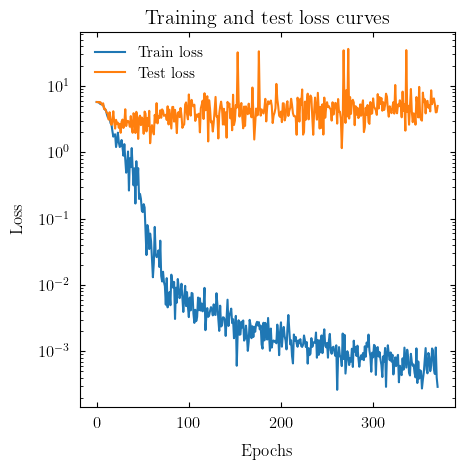

In [159]:
### Plot the loss curves
fig, ax1 = plt.subplots(ncols=1,figsize=(5,5))
ax1.plot(epoch_count, train_loss_values, label="Train loss")
ax1.plot(epoch_count, test_loss_values, label="Test loss")
ax1.set_title("Training and test loss curves")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.set_yscale('log')
ax1.legend()
plt.show()
#fig.savefig("cnn_loss.pdf", format="pdf",)

In [50]:
### Save model parameters for future iteration
#import os
#torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
#           f='cnn_batch12.pth.tar')

In [56]:
### Make predictions with a trained PyTorch model
# These for loops are ugly, because my computer didn't have enough memory to do torch.equal()
# Turn model into evaluation mode
model.eval()

test_pred_z = []
test_label_z = []
for inputs, labels in testloader:
    inputs = inputs.squeeze(0)
    inputs = inputs[:, None, :]
    test_pred = model(inputs)
    for batch_i in range(test_pred.size()[0]):
        test_pred_z.append(int(torch.argmax(test_pred[batch_i].cpu())))
        test_label_z.append(int(labels[batch_i].cpu()))
        
train_pred_z = []
train_label_z = []
for inputs, labels in trainloader:
    inputs = inputs.squeeze(0)
    inputs = inputs[:, None, :]
    train_pred = model(inputs)
    for batch_i in range(train_pred.size()[0]):
        train_pred_z.append(int(torch.argmax(train_pred[batch_i].cpu())))
        train_label_z.append(int(labels[batch_i].cpu()))


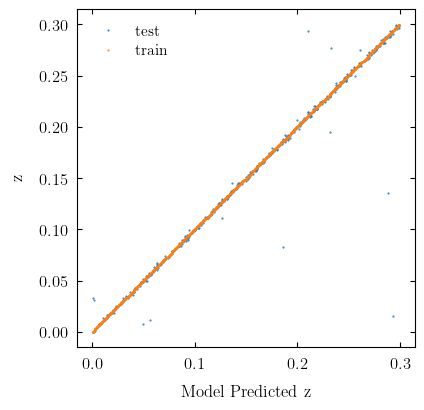

In [59]:
### Plot predicted z vs z
plt.figure()
plt.plot(np.array(test_pred_z)*0.001+0.0005,np.array(test_label_z)*0.001+0.0005,'.',label='test',markersize=1)
plt.plot(np.array(train_pred_z)*0.001+0.0005,np.array(train_label_z)*0.001+0.0005,'.',label='train',markersize=1)
#plt.plot([0,.3],[0,.3],'k')
plt.xlabel('Model Predicted z')
plt.ylabel('z')
#plt.title('Test Set Results')
plt.legend()
plt.show()

In [1]:
### Plot predicted z vs z (2-d histogram ver)
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,5))
hist_test, _, _ = np.histogram2d(np.array(test_pred_z)*0.001+0.0005,
                            np.array(test_label_z)*0.001+0.0005,
                            bins=(50,50))
hist_test = np.log10(hist_test.T[::-1]+1.0)
hist_train, _, _ = np.histogram2d(np.array(train_pred_z)*0.001+0.0005,
                            np.array(train_label_z)*0.001+0.0005,
                            bins=(50,50))
hist_train = np.log10(hist_train.T[::-1]+1.0)
im1 = ax1.imshow(hist_train, extent=[0,0.3,0,0.3],
           vmin=0, vmax=np.max(hist_train), 
           interpolation='nearest', 
           aspect='auto', 
           cmap=plt.get_cmap('Blues'))
cbar = plt.colorbar(im1,ax=ax1)
cbar.set_label(r'$\log_{10} (N+1)$')
#plt.plot([0,.3],[0,.3],'k')
ax1.set_xlabel('Model Predicted z')
ax1.set_ylabel('z')
ax1.set_title('Training Set')
im2 = ax2.imshow(hist_test, extent=[0,0.3,0,0.3],
           vmin=0, vmax=np.max(hist_test), 
           interpolation='nearest', 
           aspect='auto', 
           cmap=plt.get_cmap('Blues'))
cbar = plt.colorbar(im2,ax=ax2)
cbar.set_label(r'$\log_{10} (N+1)$')
#plt.plot([0,.3],[0,.3],'k')
ax2.set_xlabel('Model Predicted z')
ax2.set_ylabel('z')
ax2.set_title('Testing Set')
#plt.legend()
fig.tight_layout()
plt.show()
fig.savefig("cnn_results.pdf", format="pdf",)

NameError: name 'plt' is not defined

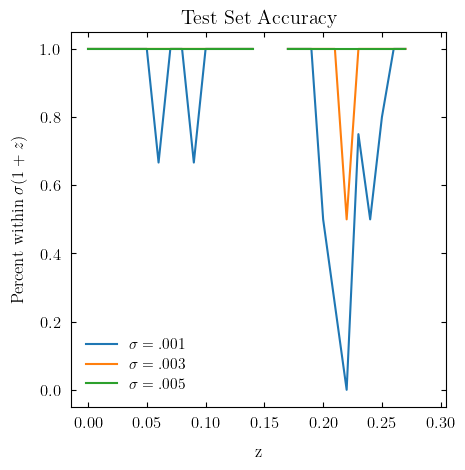

In [158]:
### Accuracy plots over redshift 
def accuracy(model_z,label_z,zrange,sig=.001):
    count = 0
    acc = 0
    model_z = np.array(model_z)*0.001+0.0005
    label_z = np.array(label_z)*0.001+0.0005
    for i in range(len(model_z)):
        if zrange[0] <= label_z[i] < zrange[1]:
            count += 1
            if abs(model_z[i]-label_z[i])<(sig*(1+label_z[i])):
                acc += 1
    if count == 0:
        return np.nan
    else:
        return acc/count

zrange = np.arange(0, 0.3, .01)
acc1 = []
acc2 = []
acc3 = []
acc4 = []
acc5 = []
for i in range(len(zrange)):
    acc1.append(accuracy(test_pred_z,test_label_z,[zrange[i],zrange[i]+.001],sig=.001))
    acc2.append(accuracy(test_pred_z,test_label_z,[zrange[i],zrange[i]+.001],sig=.002))
    acc3.append(accuracy(test_pred_z,test_label_z,[zrange[i],zrange[i]+.001],sig=.003))
    acc4.append(accuracy(test_pred_z,test_label_z,[zrange[i],zrange[i]+.001],sig=.004))
    acc5.append(accuracy(test_pred_z,test_label_z,[zrange[i],zrange[i]+.001],sig=.005))

fig, ax = plt.subplots(ncols=1,figsize=(5,5))
ax.plot(zrange,acc1,label=r'$\sigma=.001$')
#ax.plot(zrange,acc2,'.',label=r'$\sigma=.002$')
ax.plot(zrange,acc3,label=r'$\sigma=.003$')
#ax.plot(zrange,acc4,'.',label=r'$\sigma=.004$')
ax.plot(zrange,acc5,label=r'$\sigma=.005$')
ax.set_xlabel('z')
ax.set_ylabel(r'Percent within $\sigma(1+z)$')
ax.set_title('Test Set Accuracy')
plt.legend()
plt.show()
fig.savefig("cnn_test_acc.pdf", format="pdf",)